In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score,\
                            confusion_matrix, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            classification_report

from sklearn.metrics import r2_score, \
                            mean_squared_error


from prettytable import PrettyTable

In [2]:
dataset = pd.read_csv('./dev.tsv', sep='\t', low_memory=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


In [3]:
dataset.head(5)

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0


In [4]:
dataset.isna().sum()

country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72008
variety            0
winery             0
quality            0
dtype: int64

In [5]:
dataset.nunique()

country           48
description    85005
designation    27800
province         444
region_1        1206
region_2          18
variety          603
winery         14105
quality           86
dtype: int64

In [6]:
dataset = dataset.dropna(subset=['country'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120739 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120739 non-null  object 
 2   designation  84221 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120739 non-null  object 
 7   winery       120739 non-null  object 
 8   quality      120739 non-null  float64
dtypes: float64(1), object(8)
memory usage: 9.2+ MB


In [7]:
dataset.isna().sum()

country            0
description        0
designation    36518
province           0
region_1       20003
region_2       72003
variety            0
winery             0
quality            0
dtype: int64

In [8]:
dataset.duplicated().sum()


35714

The original development set contains 35,716 duplicate
objects. In this context the presence of duplicates is an
artefact probably consequent to the merger of data coming
from different sources, rather than an indication of frequently
occurring patterns. Duplicates are a significative fraction of
the development set and this may severely bias our model.
For this reason we decide to discard them from our analysis
keeping only the first occurrence of each objec

In [9]:
dataset_noDup = dataset.drop_duplicates()

In [10]:
dataset_noDup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85025 entries, 0 to 120738
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      85025 non-null  object 
 1   description  85025 non-null  object 
 2   designation  59081 non-null  object 
 3   province     85025 non-null  object 
 4   region_1     71139 non-null  object 
 5   region_2     34294 non-null  object 
 6   variety      85025 non-null  object 
 7   winery       85025 non-null  object 
 8   quality      85025 non-null  float64
dtypes: float64(1), object(8)
memory usage: 6.5+ MB


In [11]:
dataset_noDup.isna().sum()

country            0
description        0
designation    25944
province           0
region_1       13886
region_2       50731
variety            0
winery             0
quality            0
dtype: int64

In [12]:
ds_desc = dataset_noDup[['description']]
ds_desc['len'] = ds_desc.apply(len)

<ipython-input-12-714f61490de4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_desc['len'] = ds_desc.apply(len)


In [13]:
ds_desc.drop(columns=['len'], inplace=True)

C:\Users\Ooweey\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:

def get_columns():
    return ['country', 'province', 'variety', 'winery']

def categorical_handled(dataset):

    new_cols = []

    for col in get_columns():
        new_col = col+'_mean'
        new_cols.append(new_col)

        conversion = dataset.groupby([col])['quality'].mean().to_dict()
        dataset[new_col] = dataset[col].map(conversion)

    new_cols.append('description')
    new_cols.append('quality')

    return dataset[new_cols]

conv_dataset = categorical_handled(dataset_noDup)


<ipython-input-14-af840419318d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[new_col] = dataset[col].map(conversion)


In [15]:
# country_prob = dataset.groupby(['country'])['quality'].mean().to_dict()
#
# dataset['country_mean'] = dataset['country'].map(country_prob)
#
# print(dataset[['country', 'country_mean']].head())
#
# dataset['country_mean'] = dataset['country_mean'].round(2)
# dataset['country_mean'].head(10)
#
# print(dataset.isna().sum())

In [16]:
conv_dataset.isna().sum()

country_mean     0
province_mean    0
variety_mean     0
winery_mean      0
description      0
quality          0
dtype: int64

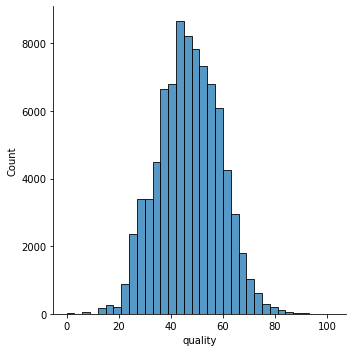

In [17]:
sns.displot(conv_dataset, x="quality",binwidth=3)

In [18]:
descs = conv_dataset['description'][:5]

In [19]:
print(len(descs[0]))
print(descs[0])

184
A creamed pear wine, with an attractive tang of orange zest. It is light, bright, vibrant, very fruity. The acidity does seem to be excessive, so give this wine a few months in bottle.


In [20]:
import string

exclist = string.punctuation + string.digits
table = str.maketrans('', '', exclist)

def remove_punct(texts):
    # print(texts)
    for i, text in enumerate(texts):
        texts = texts.translate(table)

    return texts

In [21]:

import nltk

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
# print(stop_words,'\n')

descs = descs.str.lower()
print(descs[0],'\n', len(descs[0]))

# descs = remove_punct(descs)
print(descs[0],'\n', len(descs[0]))

a creamed pear wine, with an attractive tang of orange zest. it is light, bright, vibrant, very fruity. the acidity does seem to be excessive, so give this wine a few months in bottle. 
 184
a creamed pear wine, with an attractive tang of orange zest. it is light, bright, vibrant, very fruity. the acidity does seem to be excessive, so give this wine a few months in bottle. 
 184


In [22]:
tokenized_sent = []

for desc in descs:
    asd = word_tokenize(desc)
    # print(asd)
    tokenized_sent.append(asd)

In [23]:
''' filtering stopwords '''
filtered_sent=[]
for phrase in tokenized_sent:
    filt_phr = []

    for w in phrase:
        if w not in stop_words:
            filt_phr.append(w)

    filtered_sent.append(filt_phr)

print("Tokenized Sentence:",tokenized_sent[0])
print("Filterd Sentence:",filtered_sent[0])

Tokenized Sentence: ['a', 'creamed', 'pear', 'wine', ',', 'with', 'an', 'attractive', 'tang', 'of', 'orange', 'zest', '.', 'it', 'is', 'light', ',', 'bright', ',', 'vibrant', ',', 'very', 'fruity', '.', 'the', 'acidity', 'does', 'seem', 'to', 'be', 'excessive', ',', 'so', 'give', 'this', 'wine', 'a', 'few', 'months', 'in', 'bottle', '.']
Filterd Sentence: ['creamed', 'pear', 'wine', ',', 'attractive', 'tang', 'orange', 'zest', '.', 'light', ',', 'bright', ',', 'vibrant', ',', 'fruity', '.', 'acidity', 'seem', 'excessive', ',', 'give', 'wine', 'months', 'bottle', '.']


In [24]:

def text_preproc(phrase):
    filt_ph = []

    phrase = word_tokenize(remove_punct(phrase).lower())

    for w in phrase:
        if w not in stop_words:
            filt_ph.append(w)

    return filt_ph

conv_dataset['description'] = conv_dataset['description'].apply(text_preproc)

KeyboardInterrupt: 

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

conv_dataset['description'] = conv_dataset['description'].apply(lemmatize_sentence)

In [ ]:
desc_prep = conv_dataset[['description']]

In [ ]:
desc_prep['lenght'] = desc_prep['description'].apply(len)

In [ ]:
ds_desc['description'] = ds_desc['description'].str.lower()

In [ ]:
ds_desc['description'] = ds_desc['description'].apply(remove_punct)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3))

X_tfidf = vectorizer.fit_transform(ds_desc['description'])

In [ ]:
from sklearn.feature_extraction import DictVectorizer